# Simulation
- In this notebook wee run the actual simulation and the decision making as defined by both the optimal strategy from the Vfs parameters computation notebook as well as the heuristic strategies. 

In [1]:
import sys
import os
from os import listdir
from os.path import isfile, join

sys.path.append("/Users/filiprolenec/Desktop/MT/MTpython/src")

In [2]:
from gas_example.enum_types import PowerplantState
from gas_example.simulation.simulation import run_simulation
from  gas_example.simulation.state import State
import gas_example.simulation.strategy as strategy

In [3]:
import matplotlib.pyplot as plt
from progressbar import progressbar
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()

# Baseline strategies  
- Build one stage and run all the time
- Build one stage and run only when it is profitable

In [4]:
initial_state = State(24,9,39,PowerplantState.NOT_BUILT,0)

In [5]:
[f for f in listdir("saved_vfs") if isfile(join("saved_vfs", f))]


['vfs_12_21_2020.pkl',
 'vfs_12_20_2020.pkl',
 'vfs_2020-12-24_H10.pkl',
 'vfs_12_22_2020.pkl']

In [6]:
strategy_0 = strategy.HeuristicStrategy(strategy.heuristic_strategy_function_0)
strategy_1 = strategy.HeuristicStrategy(strategy.heuristic_strategy_function_1)
strategy_2 = strategy.HeuristicStrategy(strategy.heuristic_strategy_function_2)

opt_strategy = strategy.OptimalStrategy("saved_vfs/vfs_2020-12-24_H10.pkl")

strategies = [strategy_0, strategy_1, strategy_2, opt_strategy]


In [7]:
results_final = {}
for i in range(len(strategies)):
    results = []
    for j in progressbar(range(5000)):
        results.append(run_simulation(strategies[i], initial_state))
    results_final[i]= results

100% (5000 of 5000) |####################| Elapsed Time: 0:01:35 Time:  0:01:35
100% (5000 of 5000) |####################| Elapsed Time: 0:01:28 Time:  0:01:28
100% (5000 of 5000) |####################| Elapsed Time: 0:01:28 Time:  0:01:28
100% (5000 of 5000) |####################| Elapsed Time: 2:25:41 Time:  2:25:41


In [16]:
def plot_results(results): 
    
    flatten = lambda t: [item for sublist in t.values() for item in sublist]
    all_results = flatten(results_final)
    max_value_displayed = np.percentile(all_results, 98)
    min_value_displayed = np.percentile(all_results, 2)
    
    total_min = min([min(results_final[i]) for i in range(len(results_final))])
    total_min = min_value_displayed
    total_max = max_value_displayed

    width = (total_max-total_min)/20
    b = [total_min +i*width for i in range(20)]
    
    df = pd.DataFrame(results_final)
    means = [np.mean(df[i]) for i in range(len(results_final))]
    colors = sns.color_palette()[0:4]

    fig, ax = plt.subplots(figsize = (12,6), dpi = 100)

    plt.hist(df, bins = b, label = [f"Strategy_{i}" for i in df.columns])

    trans = ax.get_xaxis_transform()


    for i,mean in enumerate(means):
        plt.axvline(x=mean,linestyle = "dashed", color = colors[i])
        plt.text(mean+5, 0.5+i*0.05, round(mean),transform = trans,  color = colors[i])
    plt.xlabel("M of EUR")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Baseline strategies and their expected PCEs")
    plt.show()

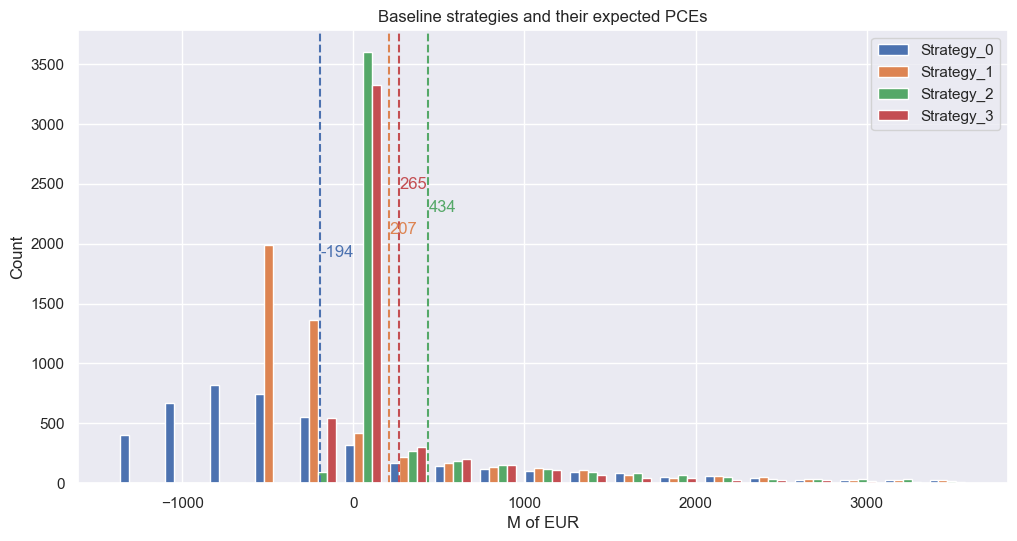

In [17]:
 plot_results(results_final)

### Comparing the result value to the one given by the value function. 

In [10]:
vfs_0 = opt_strategy.vfs[0]

In [11]:
expected_utility = vfs_0.compute_value(initial_state)

In [12]:
def uf_2_inv(y):
    if y < 0:
        thousands = -((-y) ** 1.2)
    else:
        thousands = y ** 1.25

    return thousands * 1000

In [13]:
uf_2_inv(expected_utility)/1_000_000

6.291752820799121

## Go in detail
- The problem now is that when optimizing V(s_t) we take (s_t,exp(utility)) and make the linear model. But for that we use for the computation of s_t's exp(utility) the optimal action, determined by the zero vf's. 
- Like this the action of not doing anything will always be the optimal action and the model will not evaluate V(s_t) correctly. 

- I need to return to literature and see, how V(s_t) is optimized. 

- I have an idea that we could set up the initial values not 0 but super extreme, so that the optimal actions will dissapear with the realization. 
- Second idea is to randomize the actions. 

# 20.12.
- I did run the optimal strategy and it made more money, no surprise there, but happy anyway. 
- Further analysis can be done on this. 
- This result shows that is is possible to interpret the investment problem. 


##### 